**<h1 style="text-align: center;">[Your Project Title]</h1>**

**<h3 style="text-align: center;">[Your Name]</h3>**

---

## **Section 1. Business Understanding**

### **1.1 Context**

The dataset contains customer information from a telecom company including demographics, services subscribed, account information, and churn status. The business context is to predict customer churn to enable targeted retention strategies.

### **1.2 Problem Statements**

- Which customers are likely to churn?
- What factors influence customer churn the most?
- How can the company reduce churn and improve customer retention?

### **1.3 Goals**

- Develop a predictive model to classify customers as churn or no churn.
- Identify key features affecting churn.
- Provide actionable insights for business to reduce churn.

### **1.4 Analytical Approach**

- Use supervised machine learning classification techniques.
- Data preprocessing including cleaning, feature engineering.
- Model development with benchmarking, tuning, and evaluation.
- Model explanation using feature importance and SHAP values.

### **1.5 Metric Evaluation (Business Metric, Machine Learning Evaluation Metric)**

- Business Metric: Reduction in churn rate.
- Machine Learning Evaluation Metric: Accuracy, Precision, Recall, F1-score, ROC-AUC.

### **1.6 Success Criteria**

- Achieve high classification performance (e.g., ROC-AUC > 0.80).
- Provide interpretable insights for business decisions.
- Demonstrate model effectiveness on unseen data.

## **Section 2. Data Understanding**

### **2.1 General Information**

- Dataset contains customer records with attributes related to demographics, services, contracts, billing, and churn.
- Target variable: Churn (Yes/No).

In [1]:
# Suppress warnings globally
import warnings
warnings.filterwarnings('ignore')

# Core data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Missing data visualization
import missingno as msno

# Statistical modeling and diagnostics
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning as SmConvergenceWarning
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning and preprocessing libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, StandardScaler

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE, ADASYN

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import (make_scorer, fbeta_score, classification_report, roc_auc_score, brier_score_loss,
                             precision_recall_curve, RocCurveDisplay, roc_curve, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Other utilities
from scipy.stats import uniform
import shap

# Configure pandas display options
pd.set_option('display.max_columns', None)


In [2]:
real_df = pd.read_csv(r'C:\Users\User\Documents\Purwadhika\JCDS 2602\Capstone Project\telco-churn\data\raw\data.csv')
df = real_df.copy()

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB
None


,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


### **2.2 Feature Information**

| Feature            | Description                                      | Impact to Business                                         |
|--------------------|------------------------------------------------|------------------------------------------------------------|
| customerID         | Unique customer identifier                       | Identification, no direct impact                            |
| gender             | Customer gender (Male, Female)                   | Possible demographic influence                              |
| SeniorCitizen      | Whether the customer is a senior citizen (0,1)  | May affect churn due to different needs                    |
| Partner            | Whether customer has a partner (Yes, No)        | Social factors influencing churn                            |
| Dependents         | Whether customer has dependents (Yes, No)       | Social factors influencing churn                            |
| tenure             | Number of months customer has stayed             | Longer tenure usually means lower churn                     |
| PhoneService       | Whether customer has phone service (Yes, No)    | Service usage influence                                     |
| MultipleLines      | Whether customer has multiple lines (Yes, No, No phone service) | Service usage influence                                     |
| InternetService    | Type of internet service (DSL, Fiber optic, No) | Service type impact on churn                                |
| OnlineSecurity     | Whether customer has online security (Yes, No, No internet service) | Service feature impact                                      |
| OnlineBackup       | Whether customer has online backup (Yes, No, No internet service) | Service feature impact                                      |
| DeviceProtection   | Whether customer has device protection (Yes, No, No internet service) | Service feature impact                                      |
| TechSupport        | Whether customer has tech support (Yes, No, No internet service) | Service feature impact                                      |
| StreamingTV        | Whether customer streams TV (Yes, No, No internet service) | Service feature impact                                      |
| StreamingMovies    | Whether customer streams movies (Yes, No, No internet service) | Service feature impact                                      |
| Contract           | Contract type (Month-to-month, One year, Two year) | Contract length impact on churn                             |
| PaperlessBilling   | Whether customer uses paperless billing (Yes, No) | Billing preference impact                                   |
| PaymentMethod      | Payment method used                               | Billing method impact                                       |
| MonthlyCharges     | Monthly charges                                  | Financial factor influencing churn                          |
| TotalCharges       | Total charges to date                            | Financial factor influencing churn                          |
| Churn              | Whether customer churned (Yes, No)              | Target variable                                            |

### **2.3 Missing Values Checking**

Lorem ipsum

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64


<Axes: >

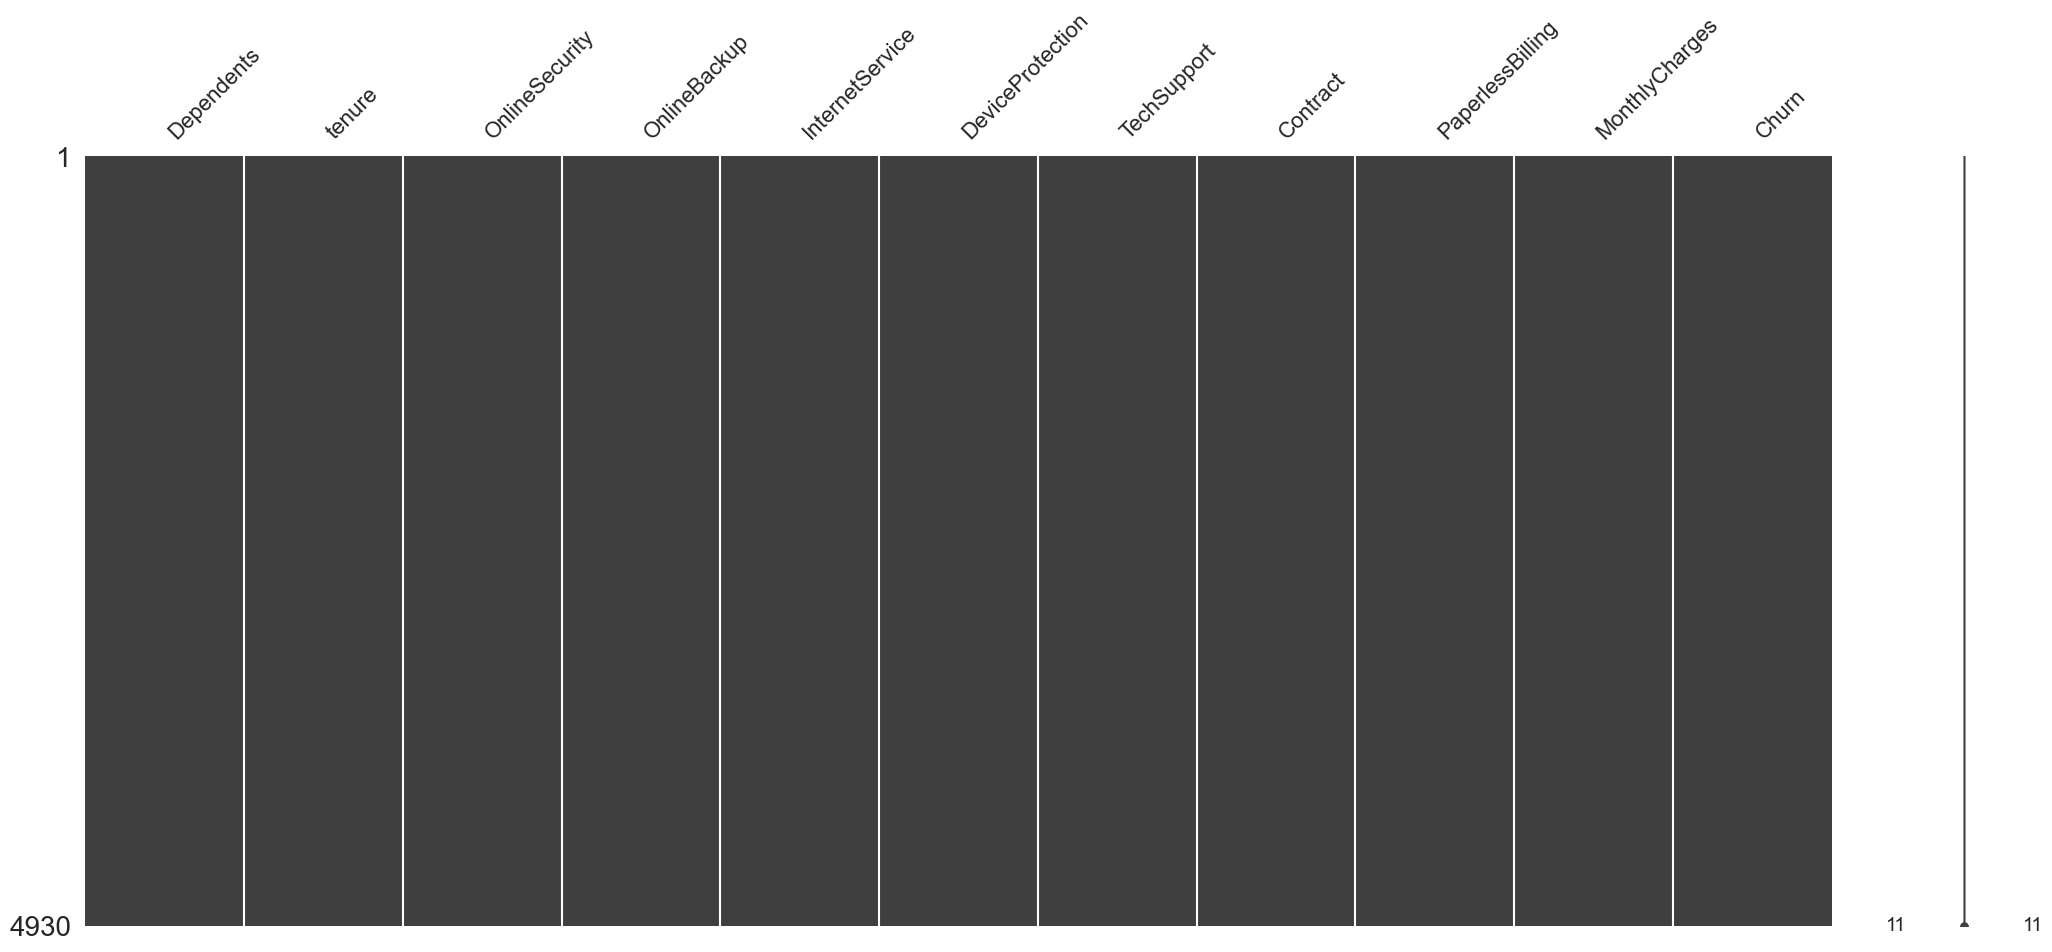

In [3]:
print(df.isnull().sum())
msno.matrix(df)

### **2.4 Duplicated Values Checking**

- Check for duplicated customerID or rows; no explicit duplicates noted.

In [4]:
df.duplicated().sum()

77

### **2.5 Dataset Restructuring for Better EDA**

In [5]:
categories = df.select_dtypes(include=['object']).columns.tolist()
df[categories] = df[categories].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Dependents        4930 non-null   category
 1   tenure            4930 non-null   int64   
 2   OnlineSecurity    4930 non-null   category
 3   OnlineBackup      4930 non-null   category
 4   InternetService   4930 non-null   category
 5   DeviceProtection  4930 non-null   category
 6   TechSupport       4930 non-null   category
 7   Contract          4930 non-null   category
 8   PaperlessBilling  4930 non-null   category
 9   MonthlyCharges    4930 non-null   float64 
 10  Churn             4930 non-null   category
dtypes: category(9), float64(1), int64(1)
memory usage: 121.6 KB


### **2.6 Exploratory Data Analysis (EDA)**

#### **2.6.1 Outlier Analysis**

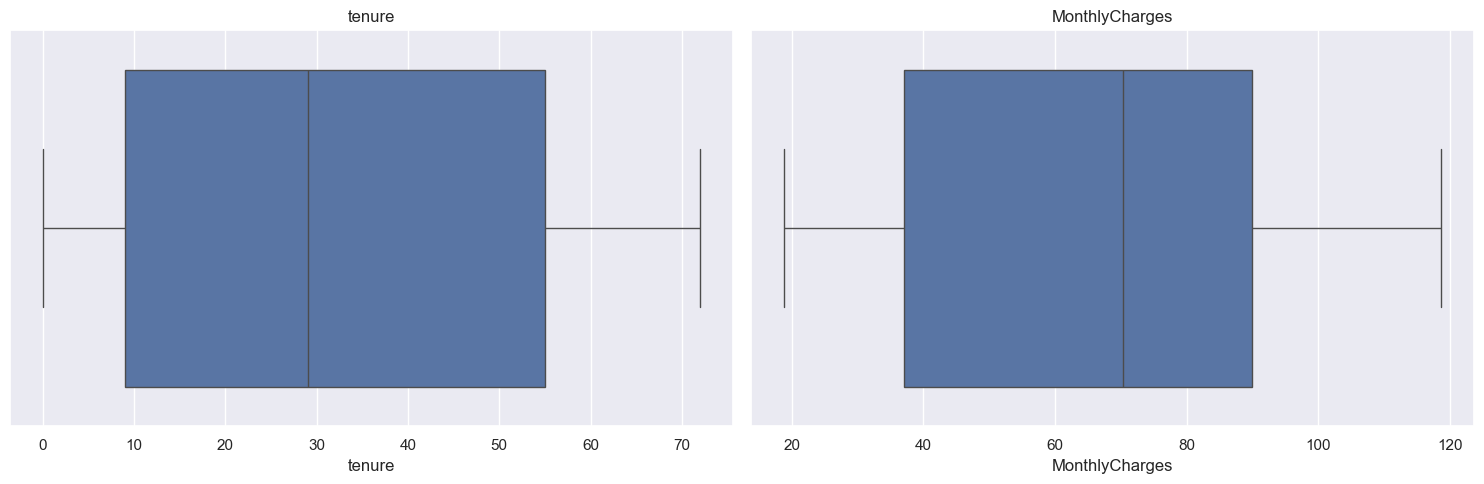

In [6]:
numerics = df.select_dtypes(include=['float64','int64']).columns.tolist()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(numerics):
    sns.boxplot(x=df[col], orient='h', ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#### **2.6.2 Unique Values Analysis**

In [7]:
columns = df.select_dtypes(include=['category']).columns
unique = dict()
nunique = dict()
for col in columns:
    unique[col] = df[col].nunique()

for col in columns: 
    nunique[col] = df[col].unique().tolist()

unique_df = pd.DataFrame({'unique':unique, 'nunique':nunique})
unique_df

,unique,nunique
Dependents,2,"[Yes, No]"
OnlineSecurity,3,"[No, Yes, No internet service]"
OnlineBackup,3,"[No, Yes, No internet service]"
InternetService,3,"[DSL, Fiber optic, No]"
DeviceProtection,3,"[Yes, No internet service, No]"
TechSupport,3,"[Yes, No, No internet service]"
Contract,3,"[Month-to-month, Two year, One year]"
PaperlessBilling,2,"[Yes, No]"
Churn,2,"[Yes, No]"


#### **2.6.3 Proportion Analysis**

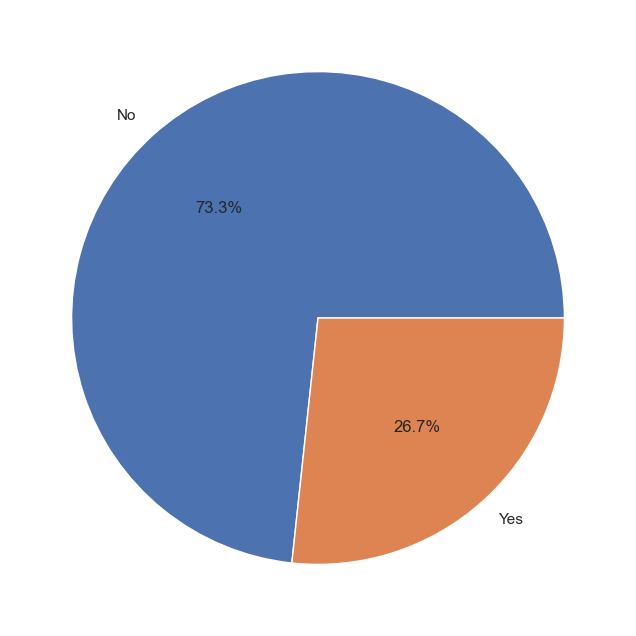

In [8]:
churn_propo = df['Churn'].value_counts()

plt.figure(figsize=(12,8))
plt.pie(churn_propo, labels=churn_propo.index, autopct='%1.1f%%');

#### **2.6.4 Feature Distribution Analysis**

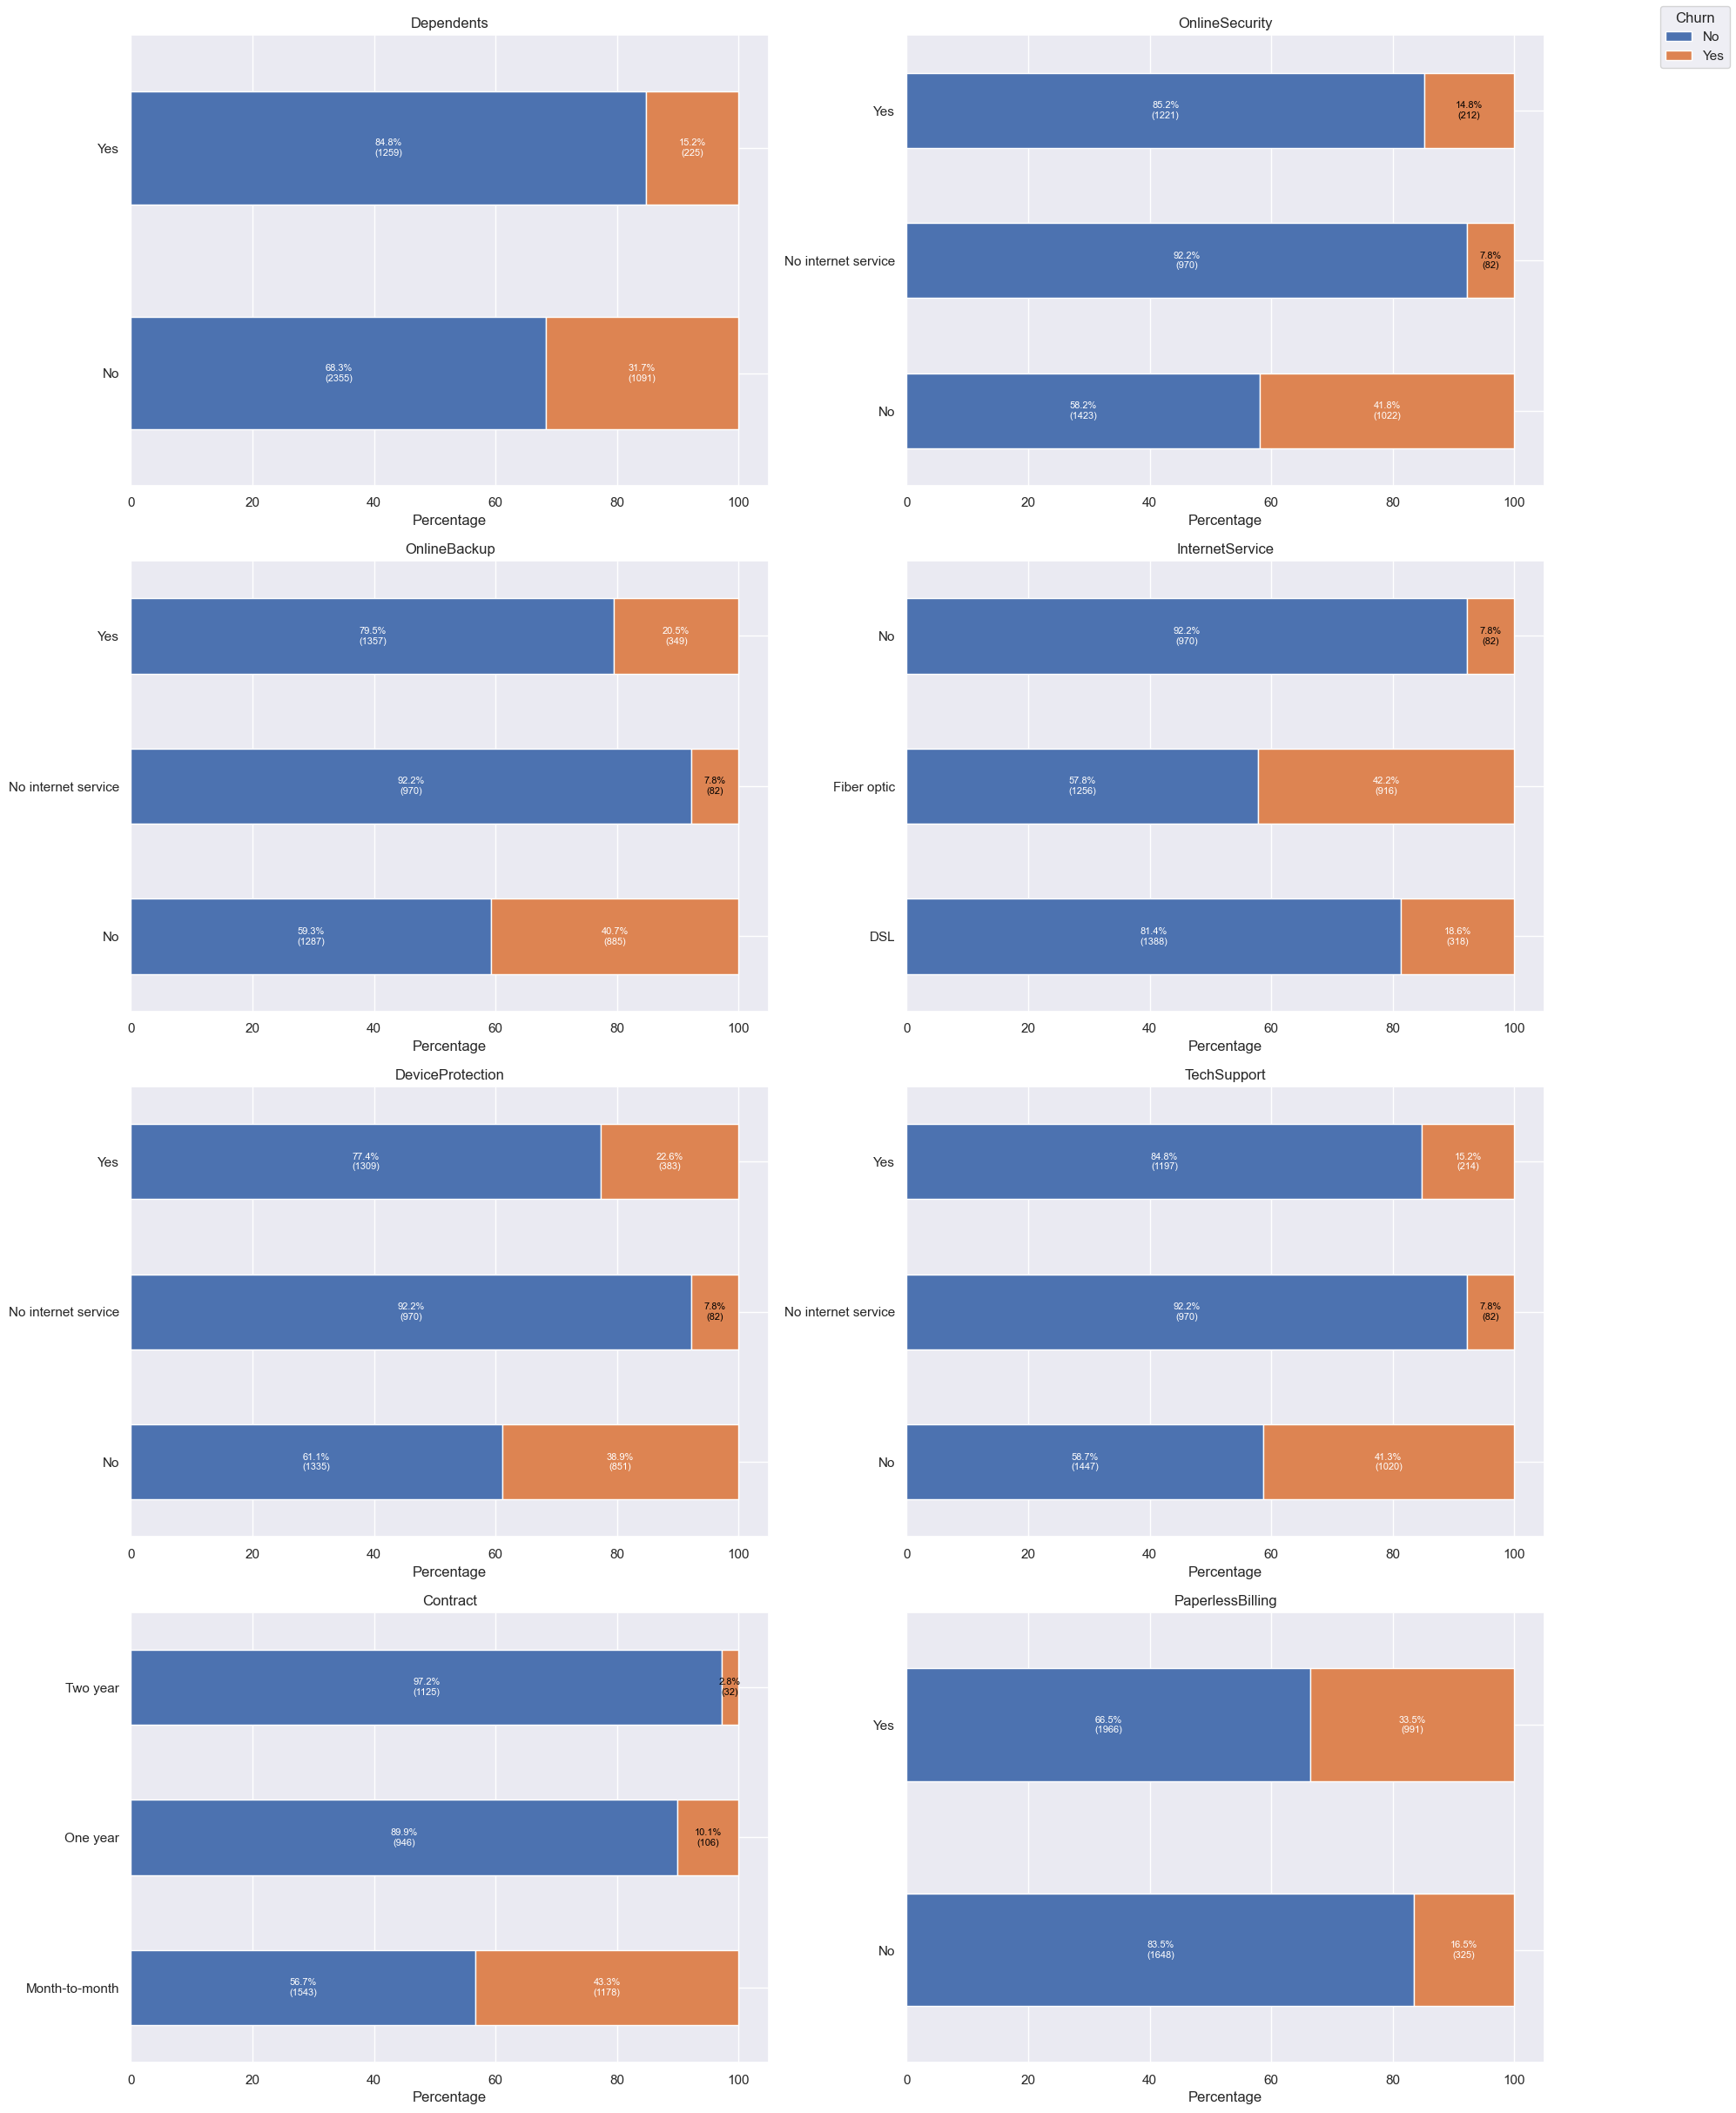

In [9]:
categorical_cols = df.select_dtypes(include='category').columns.drop('Churn')

num_plots = len(categorical_cols)
cols = 2
rows = 8

fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 6))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]

    # Compute counts per category and churn status with observed=True
    counts = df.groupby([col, 'Churn'], observed=True).size().unstack(fill_value=0)

    # Convert counts to percentages per category level (row-wise)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot horizontal stacked bar chart on the subplot axis
    percentages.plot(kind='barh', stacked=True, ax=ax, legend=False)

    ax.set_title(f'{col}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')

    # Annotate each segment with percentage and count
    for j, (index, row) in enumerate(percentages.iterrows()):
        cum_width = 0
        for churn_status in percentages.columns:
            pct = row[churn_status]
            cnt = counts.loc[index, churn_status]
            if pct > 0:
                label = f'{pct:.1f}%\n({cnt})'
                ax.text(cum_width + pct / 2, j, label, ha='center', va='center', fontsize=8,
                        color='white' if pct > 15 else 'black')
                cum_width += pct

# Remove any unused subplots
for k in range(i + 1, len(axes)):
    fig.delaxes(axes[k])

# Create one legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Churn', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for legend
plt.show()


#### **2.6.5 Correlation Analysis**

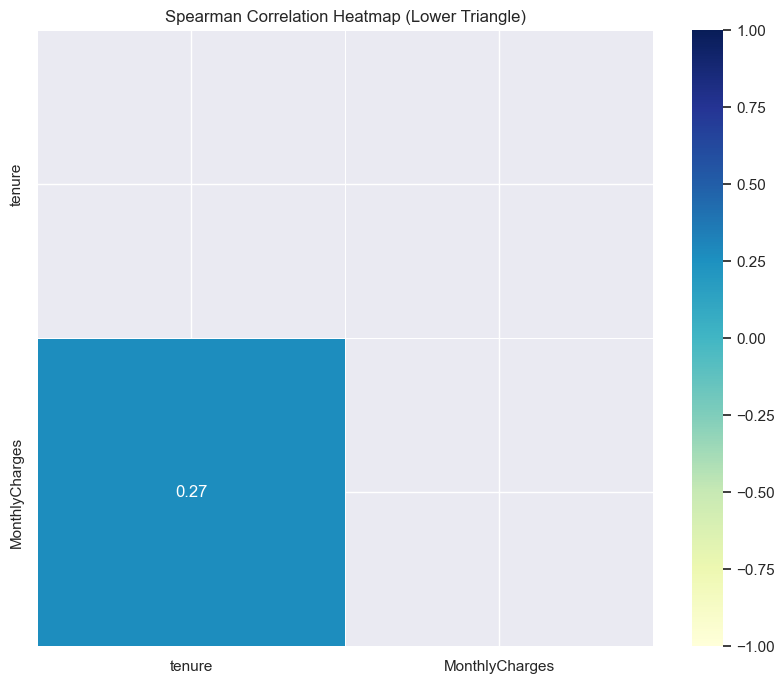

In [10]:
# Assuming df is your DataFrame
# Compute Spearman correlation matrix for numeric columns
corr = df.corr(numeric_only=True, method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with the mask applied to show only the lower triangle
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Spearman Correlation Heatmap (Lower Triangle)')
plt.show()


#### **2.6.6 Correlation Analysis**

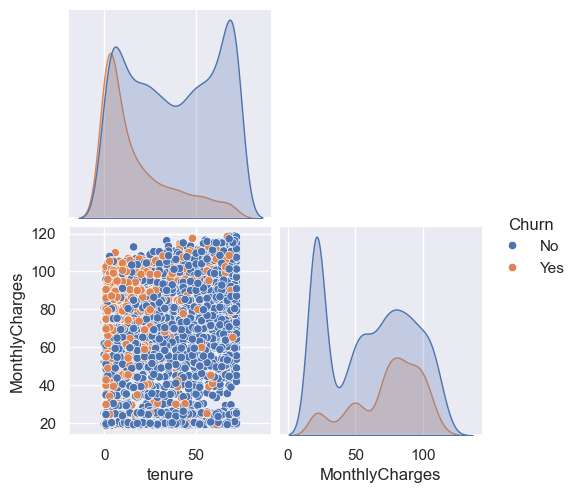

In [11]:
sns.pairplot(df, hue='Churn', corner=True);

#### **2.6.7 Statistics Summary**

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,4930.0,32.401217,24.501193,0.0,9.00,29.00,55.00,72.00
MonthlyCharges,4930.0,64.883032,29.923960,18.8,37.05,70.35,89.85,118.65


In [13]:
df.describe(include=['object','category']).transpose()

,count,unique,top,freq
Dependents,4930,2,No,3446
OnlineSecurity,4930,3,No,2445
OnlineBackup,4930,3,No,2172
InternetService,4930,3,Fiber optic,2172
DeviceProtection,4930,3,No,2186
TechSupport,4930,3,No,2467
Contract,4930,3,Month-to-month,2721
PaperlessBilling,4930,2,Yes,2957
Churn,4930,2,No,3614


- Tenure ranges from 0 to 72 months.
- MonthlyCharges vary widely, indicating different service usage.
- Churn rate can be calculated from the 'Churn' column (proportion of 'Yes').

## **Section 3. Data Preparation**

### **3.1 Feature Engineering**

In [14]:
df['TotalCharges'] = df['tenure'] * df['MonthlyCharges']
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn,TotalCharges
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes,656.1
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No,1157.1
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes,3062.4
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No,5014.8
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No,70.8


### **3.2 Target Labelling**

In [15]:
# Churn target labeling
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

### **3.3 Define X and y**

In [16]:
# Define features and target variable.
X = df.drop(columns=['Churn']) 
y = df['Churn']

### **3.4 Train Test Split**

In [17]:
# Train Test Split (stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **3.5 Data Transformation**

In [18]:
# Identify categorical columns (excluding target 'Churn')
categorical_cols = [col for col in df.select_dtypes(include=['category']).columns if col != 'Churn']

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify binary columns to map 'No' -> 0 and 'Yes' -> 1
binary_cols = unique_df[unique_df['unique'] == 2].index.tolist()
binary_cols = [col for col in binary_cols if col not in ['Churn']]

# Separate categorical columns into binary and non-binary
categorical_cols_no_binary = [col for col in categorical_cols if col not in binary_cols]

# Function to map 'No' to 0 and 'Yes' to 1 in binary columns
def map_binary_yes_no(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=binary_cols)
    for col in X.columns:
        X[col] = X[col].map({'No': 0, 'Yes': 1}).astype(np.int64)
    return X.values

# Pipeline for numeric columns: imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', RobustScaler())
])

# Pipeline for binary columns: map Yes/No to 0/1
binary_transformer = Pipeline(steps=[
    ('map_yes_no', FunctionTransformer(map_binary_yes_no))
])

# Pipeline for other categorical columns: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('binary', binary_transformer, binary_cols),
        ('cat', categorical_transformer, categorical_cols_no_binary)
    ],
    remainder='passthrough'  # pass through other columns and target
)


## **Section 4. Modeling**

### **4.1 Initialization**

- Initialize model pipeline and evaluation metrics.
- Define custom metrics if needed.
- Create a workflow of the experiment ?

### **4.2 Developing the Model Pipeline**

- Build machine learning pipeline including preprocessing and model.

In [19]:
# Optimized models dictionary with n_jobs where supported
models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, random_state=42),
    'k-NN': KNeighborsClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
}

# Use only recall scoring
scoring = ['recall']

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

list_scores = []

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    for score in scoring:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=score, n_jobs=-1)
        list_scores.append({
            'Model': model_name,
            'Metric': score,
            'Mean Score': np.mean(scores),
            'Std Dev': np.std(scores)
        })

### **4.3 Model Benchmarking (Comparing model base performance)**

- Evaluate multiple algorithms (e.g., Logistic Regression, Random Forest, XGBoost).

In [20]:
results_df = pd.DataFrame(list_scores)
results_df = results_df.sort_values(by=['Mean Score', 'Std Dev'], ascending=False)
results_df[results_df['Metric'] == 'recall']

,Model,Metric,Mean Score,Std Dev
0,Logistic Regression,recall,0.534687,0.030207
9,LightGBM,recall,0.532670,0.044481
3,Gradient Boosting,recall,0.519431,0.031206
8,XGBoost,recall,0.508946,0.037485
7,k-NN,recall,0.490007,0.014979
1,Decision Tree,recall,0.476719,0.019208
2,Random Forest,recall,0.476673,0.030669
6,SVM,recall,0.447271,0.022860
5,Bagging,recall,0.428265,0.025116
4,AdaBoost,recall,0.412999,0.059412


### **4.4 VIF Analysis**

In [21]:
# After preprocessing, create a DataFrame of numeric features for VIF calculation
# Apply the preprocessing pipeline to the training data (without the classifier)
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Convert to DataFrame for easier handling
# Get feature names after preprocessing
def get_feature_names(preprocessor):
    feature_names = []

    # Numeric columns
    feature_names.extend(numeric_cols)

    # Binary columns (mapped to 0/1)
    feature_names.extend(binary_cols)

    # One-hot encoded categorical columns
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols_no_binary)
    feature_names.extend(cat_features)

    return feature_names

feature_names = get_feature_names(preprocessor)

# Create DataFrame
X_vif = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)


,feature,VIF
13,TechSupport_No internet service,inf
11,DeviceProtection_No internet service,inf
5,OnlineSecurity_No internet service,inf
10,InternetService_No,inf
7,OnlineBackup_No internet service,inf
2,TotalCharges,11.758656
1,MonthlyCharges,7.662679
0,tenure,6.604636
9,InternetService_Fiber optic,3.994744
16,Contract_Two year,3.103916


### **4.5 Tune Model**

- Remove VIF Variables
- Resampling using SMOTE/ADASYN/etc. (Using ImbLearn)
- Hyperparameter tuning using grid search or randomized search.

In [22]:
# Custom transformer to drop features with high VIF
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10):
        self.threshold = threshold
        self.features_to_drop_ = []
        self.feature_names_ = None

    def fit(self, X, y=None):
        if hasattr(X, "toarray"):
            X = X.toarray()
        X_df = pd.DataFrame(X, columns=self.feature_names_)

        vif_data = pd.DataFrame()
        vif_data['feature'] = X_df.columns
        vif_vals = []
        for i in range(X_df.shape[1]):
            try:
                vif = variance_inflation_factor(X_df.values, i)
            except Exception:
                vif = np.inf
            vif_vals.append(vif)
        vif_data['VIF'] = vif_vals

        self.features_to_drop_ = vif_data[(vif_data['VIF'] == np.inf) | (vif_data['VIF'] > self.threshold)]['feature'].tolist()
        return self

    def transform(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        X_df = pd.DataFrame(X, columns=self.feature_names_)
        X_reduced = X_df.drop(columns=self.features_to_drop_, errors='ignore')
        return X_reduced.values

    def set_feature_names(self, feature_names):
        self.feature_names_ = feature_names
        return self

# Fungsi untuk mendapatkan feature names dari preprocessor secara dinamis
def get_feature_names(preprocessor):
    feature_names = []
    feature_names.extend(numeric_cols)
    feature_names.extend(binary_cols)
    # Jika gender ada di pipeline dan diproses terpisah, tambahkan di sini jika perlu
    if 'gender' in X_train.columns:
        feature_names.append('gender')
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols_no_binary)
    feature_names.extend(cat_features)
    return feature_names

feature_names = get_feature_names(preprocessor)

# Inisialisasi VIFSelector dengan feature names
vif_selector = VIFSelector(threshold=50).set_feature_names(feature_names)

# Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)

# Resamplers
resamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definisikan distribusi parameter dengan kondisi agar l1_ratio hanya untuk elasticnet
param_dist = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['saga'],
        # tidak ada l1_ratio di sini
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': uniform(0, 1)
    }
]

# Loop untuk tiap resampler
for name, sampler in resamplers.items():
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('vif_selector', vif_selector),
        ('resampler', sampler),
        ('classifier', logreg)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=50,
        scoring='recall',
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1,
        refit=True
    )


    random_search.fit(X_train, y_train)

    # Cetak hasil terbaik
    print(f"Best recall score with {name}: {random_search.best_score_:.4f}")
    print(f"Best parameters with {name}: {random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best recall score with SMOTE: 0.7968
Best parameters with SMOTE: {'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best recall score with ADASYN: 0.8490
Best parameters with ADASYN: {'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


### **4.6 Analyze Model**

- Evaluate model on test data.
- Residual analysis and learning curves.
- Learning Curve Inspection ?

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       723
           1       0.49      0.85      0.62       263

    accuracy                           0.72       986
   macro avg       0.71      0.76      0.70       986
weighted avg       0.81      0.72      0.74       986

ROC-AUC Score: 0.8519


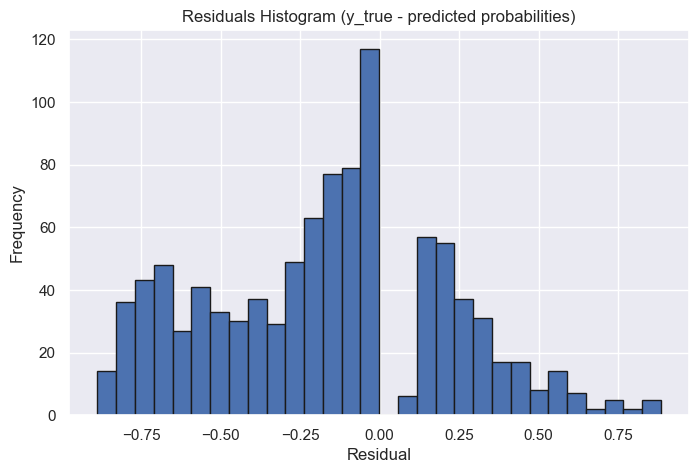

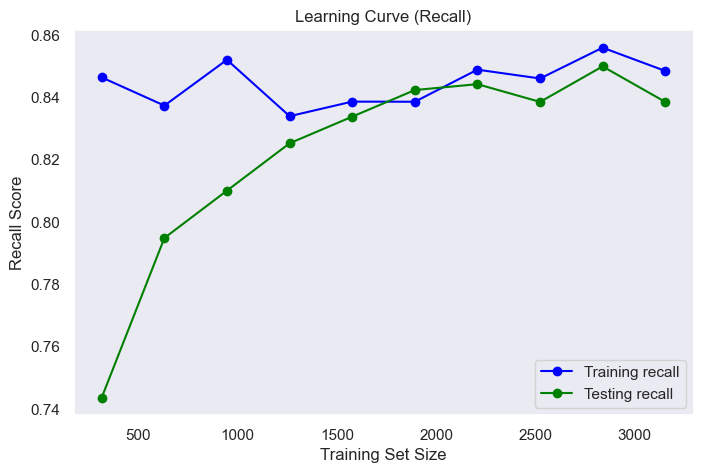

In [23]:
best_pipeline = random_search.best_estimator_

# Predict on test data
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Residual analysis: plot histogram of residuals (y_test - predicted probabilities)
residuals = y_test.astype(float) - y_proba
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Histogram (y_true - predicted probabilities)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X_train, y_train,
    cv=5, scoring='recall', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training recall')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Testing recall')
plt.title('Learning Curve (Recall)')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')
plt.legend(loc='best')
plt.grid()
plt.show()

### **4.7 Model Calibration (Classification Only)**

- Calibrate probabilities for better decision thresholding.

Recall Score before threshold tuning (threshold=0.5): 0.8479
Best threshold by Youden’s J statistic: 0.4243
TPR: 0.9163, FPR: 0.3665, ROC AUC: 0.8519
Recall Score after threshold tuning (threshold=0.4243): 0.9163


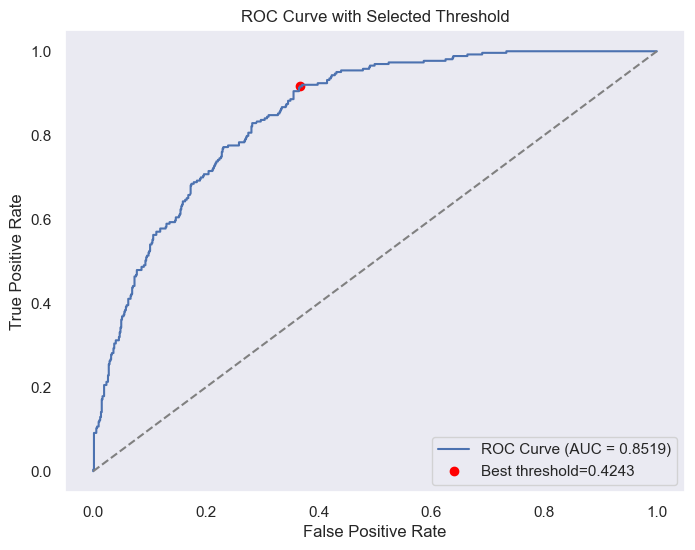

In [24]:
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Probabilitas positif prediksi dari model terkalibrasi atau model terbaik
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Prediksi kelas default dengan threshold 0.5
y_pred_default = (y_proba >= 0.5).astype(int)

# Hitung recall score sebelum threshold tuning (default threshold 0.5)
recall_before = recall_score(y_test, y_pred_default)
print(f"Recall Score before threshold tuning (threshold=0.5): {recall_before:.4f}")

# Hitung FPR, TPR, dan thresholds dari ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Hitung Youden’s J statistic (TPR - FPR)
youden_j = tpr - fpr

# Cari threshold dengan Youden’s J tertinggi
best_idx = youden_j.argmax()
best_threshold = thresholds[best_idx]

# Hitung ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Best threshold by Youden’s J statistic: {best_threshold:.4f}")
print(f"TPR: {tpr[best_idx]:.4f}, FPR: {fpr[best_idx]:.4f}, ROC AUC: {roc_auc:.4f}")

# Gunakan threshold ini untuk prediksi kelas baru
y_pred_new = (y_proba >= best_threshold).astype(int)

# Hitung recall score dengan threshold baru
recall_after = recall_score(y_test, y_pred_new)
print(f"Recall Score after threshold tuning (threshold={best_threshold:.4f}): {recall_after:.4f}")

# Evaluasi ulang dengan threshold baru
# print("Classification Report with adjusted threshold:")
# print(classification_report(y_test, y_pred_new))

# Visualisasi ROC curve dengan threshold terpilih
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best threshold={best_threshold:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Selected Threshold')
plt.legend()
plt.grid()
plt.show()

Recall Score before threshold tuning (threshold=0.5): 0.8479
Best threshold by F1-score on PR curve: 0.5972
Precision: 0.5486, Recall: 0.7719, F1-score: 0.6414
Recall Score after threshold tuning (threshold=0.5972): 0.7719


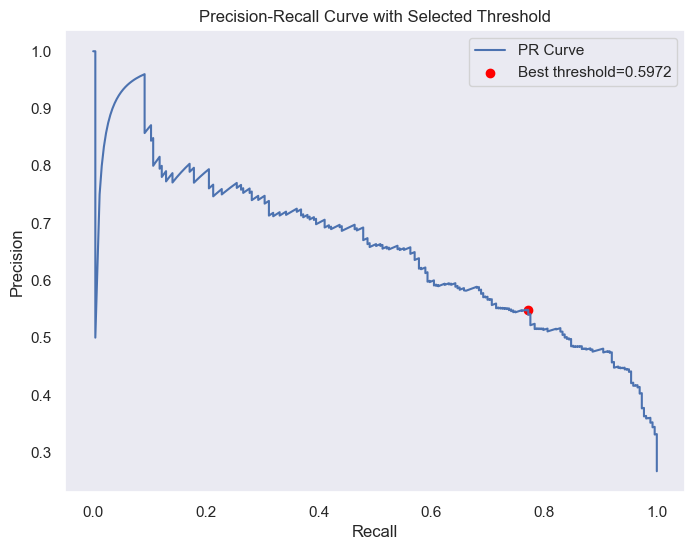

In [25]:
from sklearn.metrics import classification_report, recall_score, precision_recall_curve
import matplotlib.pyplot as plt

# Probabilitas positif prediksi dari model terkalibrasi atau model terbaik
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Prediksi kelas default dengan threshold 0.5
y_pred_default = (y_proba >= 0.5).astype(int)

# Hitung recall score sebelum threshold tuning (default threshold 0.5)
recall_before = recall_score(y_test, y_pred_default)
print(f"Recall Score before threshold tuning (threshold=0.5): {recall_before:.4f}")

# Hitung precision, recall, dan thresholds dari PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Hitung F1-score untuk setiap threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # hindari pembagian 0

# Cari threshold dengan F1-score tertinggi
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold by F1-score on PR curve: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1-score: {f1_scores[best_idx]:.4f}")

# Gunakan threshold ini untuk prediksi kelas baru
y_pred_new = (y_proba >= best_threshold).astype(int)

# Hitung recall score dengan threshold baru
recall_after = recall_score(y_test, y_pred_new)
print(f"Recall Score after threshold tuning (threshold={best_threshold:.4f}): {recall_after:.4f}")

# Evaluasi kembali menggunakan threshold baru
# print("Classification Report with adjusted threshold:")
# print(classification_report(y_test, y_pred_new))

# Visualisasi PR Curve dengan threshold terpilih
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='PR Curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best threshold={best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Selected Threshold')
plt.legend()
plt.grid()
plt.show()


## **Section 5. Evaluation**

### **5.1 Initial vs Final Model Performance**

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, recall_score

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit baseline pipeline
baseline_pipe.fit(X_train, y_train)

# 1. Prediksi dan evaluasi model baseline (asumsi baseline_pipe sudah fit)
y_proba_baseline = baseline_pipe.predict_proba(X_test)[:, 1]
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
print(f"Baseline Logistic Regression ROC AUC: {roc_auc_baseline:.4f}")

# 2. Prediksi dan evaluasi model hasil hyperparameter tuning (random_search sudah fit)
best_pipe = random_search.best_estimator_
y_proba_tuned = best_pipe.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)
print(f"Tuned Logistic Regression ROC AUC: {roc_auc_tuned:.4f}")
print(f"Best parameters: {random_search.best_params_}")

# 3. Threshold adjustment berdasarkan ROC curve (Youden’s J statistic)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_tuned)
youden_j = tpr - fpr
best_idx = youden_j.argmax()
optimal_threshold = thresholds[best_idx]
print(f"Optimal threshold from ROC curve: {optimal_threshold:.4f}")

# Prediksi kelas dengan threshold optimal
y_pred_adjusted = (y_proba_tuned >= optimal_threshold).astype(int)

# ROC AUC tetap sama karena threshold tidak ubah probabilitas
roc_auc_adjusted = roc_auc_score(y_test, y_proba_tuned)
print(f"ROC AUC after threshold adjustment (same as tuned): {roc_auc_adjusted:.4f}")

# Contoh hitung recall dengan threshold default dan threshold optimal
y_pred_default = (y_proba_tuned >= 0.5).astype(int)
recall_default = recall_score(y_test, y_pred_default)
recall_adjusted = recall_score(y_test, y_pred_adjusted)

print(f"Recall with default threshold 0.5: {recall_default:.4f}")
print(f"Recall with optimal threshold {optimal_threshold:.4f}: {recall_adjusted:.4f}")

# Ringkasan hasil
print("\nSummary:")
print(f"Baseline ROC AUC: {roc_auc_baseline:.4f}")
print(f"Tuned ROC AUC: {roc_auc_tuned:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Recall (default threshold): {recall_default:.4f}")
print(f"Recall (optimal threshold): {recall_adjusted:.4f}")

Baseline Logistic Regression ROC AUC: 0.8558
Tuned Logistic Regression ROC AUC: 0.8519
Best parameters: {'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Optimal threshold from ROC curve: 0.4243
ROC AUC after threshold adjustment (same as tuned): 0.8519
Recall with default threshold 0.5: 0.8479
Recall with optimal threshold 0.4243: 0.9163

Summary:
Baseline ROC AUC: 0.8558
Tuned ROC AUC: 0.8519
Optimal Threshold: 0.4243
Recall (default threshold): 0.8479
Recall (optimal threshold): 0.9163


### **5.2 Model Explanation and Interpretation Using Statsmodels**

In [27]:
# 1. Transform the training data with the pipeline (preprocessor + VIF selector)
# Fit preprocessor on training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Function to get feature names after preprocessing
def get_feature_names(preprocessor):
    feature_names = []
    feature_names.extend(numeric_cols)
    feature_names.extend(binary_cols)
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols_no_binary)
    feature_names.extend(cat_features)
    return feature_names

feature_names = get_feature_names(preprocessor)

# Convert preprocessed data to DataFrame with feature names
X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# Apply VIFSelector transform to remove multicollinear features
vif_selector = VIFSelector(threshold=50).set_feature_names(feature_names)
vif_selector.fit(X_train_df)
X_train_reduced = vif_selector.transform(X_train_df)

# Get final feature names after removing high VIF features
features_after_vif = [f for f in feature_names if f not in vif_selector.features_to_drop_]

# Create DataFrame for final features
X_train_final = pd.DataFrame(X_train_reduced, columns=features_after_vif)

# --- IMPORTANT: Align indices of features and target ---
# Option 1: Reset indices of both
X_train_final = X_train_final.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# 2. Add intercept column for statsmodels
X_train_final = sm.add_constant(X_train_final)

# 3. Fit logistic regression using statsmodels (unregularized for interpretation)
model_sm = sm.Logit(y_train_reset, X_train_final)
result = model_sm.fit(disp=False)

# 4. Print summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3944
Model:                          Logit   Df Residuals:                     3931
Method:                           MLE   Df Model:                           12
Date:                Wed, 14 May 2025   Pseudo R-squ.:                  0.2696
Time:                        17:45:40   Log-Likelihood:                -1671.6
converged:                       True   LL-Null:                       -2288.5
Covariance Type:            nonrobust   LLR p-value:                9.215e-257
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.8394      0.202     -4.159      0.000      -1.235      -0.444
tenure                         -2.3565      0.367     -6.421      0.000      -3.076      -1.637
MonthlyCharges                  1.2647      0.230      5.499      0.000       0.814       1.715
TotalCharges                    0.7639      0.300      2.546      0.011       0.176       1.352
Dependents                     -0.3025      0.106     -2.856      0.004      -0.510      -0.095
PaperlessBilling                0.4522      0.098      4.621      0.000       0.260       0.644
OnlineSecurity_Yes             -0.5422      0.115     -4.721      0.000      -0.767      -0.317
OnlineBackup_Yes               -0.2841      0.106     -2.674      0.008      -0.492      -0.076
InternetService_Fiber optic     0.1176      0.191      0.616      0.538      -0.257       0.492
DeviceProtection_Yes           -0.0452      0.112     -0.405      0.686      -0.264       0.174
TechSupport_Yes                -0.4632      0.119     -3.882      0.000      -0.697      -0.229
Contract_One year              -0.9623      0.142     -6.784      0.000      -1.240      -0.684
Contract_Two year              -1.4068      0.218     -6.444      0.000      -1.835      -0.979
===============================================================================================
"""

### **5.3 Feature Importances Using SHAP Values**

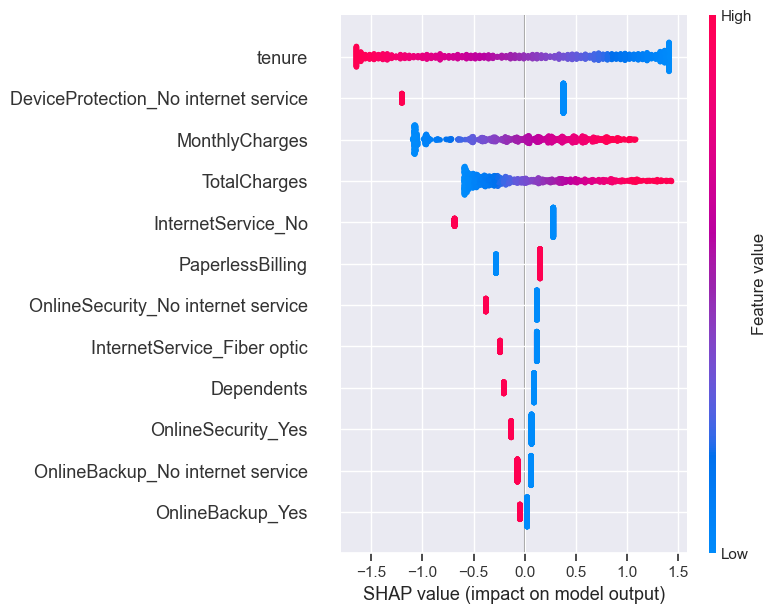

In [28]:
# Extract best pipeline
best_pipeline = random_search.best_estimator_

# Preprocessor + VIF selector pipeline
preprocessor_vif = ImbPipeline([
    ('preprocessor', best_pipeline.named_steps['preprocessor']),
    ('vif_selector', best_pipeline.named_steps['vif_selector'])
])

# Transform test data
X_test_preprocessed = preprocessor_vif.transform(X_test)

# Get feature names after preprocessing and VIF filtering
feature_names = get_feature_names(best_pipeline.named_steps['preprocessor'])
features_after_vif = [f for f in feature_names if f not in best_pipeline.named_steps['vif_selector'].features_to_drop_]

# Get classifier
model = best_pipeline.named_steps['classifier']

# Create SHAP explainer and values
explainer = shap.LinearExplainer(model, X_test_preprocessed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_preprocessed)

# SHAP summary plot
shap.summary_plot(shap_values, features=X_test_preprocessed, feature_names=features_after_vif)

### **5.3 Counterfactual analysis for churn prediction.**

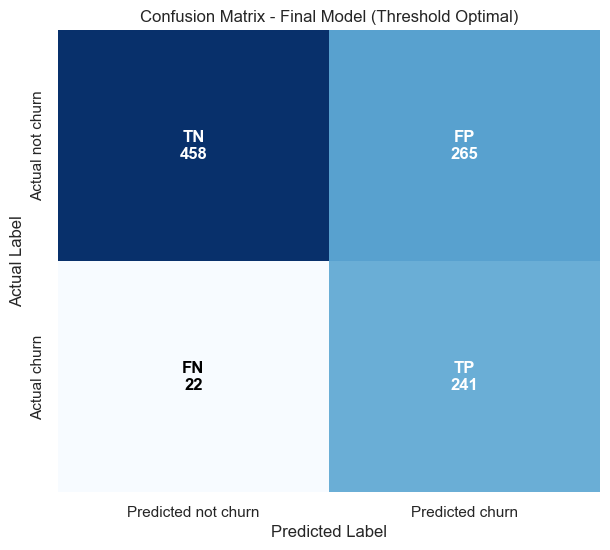

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix dengan prediksi threshold optimal
cm = confusion_matrix(y_test, y_pred_adjusted)

# Label kelas
class_labels = ['not churn', 'churn']

# Buat figure
plt.figure(figsize=(7, 6))

# Plot heatmap tanpa anotasi angka dulu
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Predicted {label}' for label in class_labels],
            yticklabels=[f'Actual {label}' for label in class_labels])

# Tambahkan anotasi angka dan label TP, TN, FP, FN
thresh = cm.max() / 2.

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Tentukan label TP, TN, FP, FN berdasarkan posisi matriks
        if i == 0 and j == 0:
            label = f'TN\n{cm[i, j]}'
        elif i == 1 and j == 1:
            label = f'TP\n{cm[i, j]}'
        elif i == 0 and j == 1:
            label = f'FP\n{cm[i, j]}'
        else:  # i == 1 and j == 0
            label = f'FN\n{cm[i, j]}'
        
        plt.text(j + 0.5, i + 0.5, label,
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black',
                 fontsize=12, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Final Model (Threshold Optimal)')
plt.show()


## **Section 6. Deployment**

### **6.1 Model Deployment Using Joblib**

### **6.2 How To Use Joblib Model**


### **6.3 Model Limitations**

- Model depends on data quality and feature relevance.
- Changes in customer behavior or services may reduce model accuracy over time.

## **Section 7. Conclusion and Recommendation**

### **7.1 Conclusion**

- Model: The developed model predicts churn with good accuracy and provides insights into key factors.
- Business: Understanding churn drivers enables targeted retention strategies.

### **7.2 Recommendation**

- Model: Regularly update and monitor model performance.
- Business: Use model insights to improve customer service, contract offerings, and billing options to reduce churn.

## **References**